# Bandit算法学习[网站优化]02——epsilon-Greedy 算法

## 参考资料

1. White J. Bandit algorithms for website optimization[M]. " O'Reilly Media, Inc.", 2013.
2. [https://github.com/johnmyleswhite/BanditsBook](https://github.com/johnmyleswhite/BanditsBook)

实验环境：jupyter python 3.7




## 一、算法介绍

epsilon-Greedy算法是在单纯的随机实验和最大化利润之间随机振荡。epsilon-Greedy算法是最容易理解的强盗算法之一，因为它试图通过一种十分简单的机制来公平地对待探索和利用这两个相反的目标: ‘抛硬币’。虽然我们需要解决一些细节来进行精确的陈述，但epsilon-Greedy算法背后的主要思想十分简单: 抛硬币，出现正面，应该`explore`。如果硬币背面朝上，应该`exploit`。

以改变网站标志的颜色来增加收入为例。我们假设Deb在绿色和红色这两种颜色之间进行抉择，她想找到一种颜色，使她的网站的新访客转化为注册用户的几率最大化。epsilon-Greedy算法试图通过以下程序找到最佳的颜色标识（图3-1中的图示），该程序按顺序应用于每个新的潜在客户。

+ 当一个新的访问者来到该网站时，该算法抛出一个硬币，出现背面的概率为epsilon。

+ 如果硬币正面朝上，算法就会`exploit`。为了`exploit`，该算法在任何用于跟踪事物的数据源中查找绿色和红色标志的历史转化率。在确定了过去成功率最高的颜色后，算法决定向新访问者展示历史上成功率最高的颜色。

+ 如果硬币不是正面朝上，而是反面朝上，算法就会进行`explore`。由于`explore`涉及随机试验所考虑的两种颜色，算法需要抛第二枚硬币在它们之间进行选择。与第一枚硬币不同，我们假设第二枚硬币正面朝上的概率是50%，一旦抛下第二枚硬币，算法就可以继续进行最后一步:

 + 如果第二枚硬币正面朝上，就向新访客展示绿色标志​:green_heart:​。
 + 如果第二枚硬币背面朝上，就向新访客展示红色标志​​:red_circle:。


![image-20230104092500696](https://note-image-1307786938.cos.ap-beijing.myqcloud.com/typora/image-20230104092500696.png)

这个算法的工作原理是(a)利用它目前知道的最佳选项，(B)在所有可用的选项中随机`explore`。事实上，可以从算法的定义中知道:

+ epsilon-Greedy有`1-epsilon`的概率`exploit`已知最佳的选项。

+ epsilon-Greedy有`epsilon/2`的概率`explore`已知最佳的选项。

+ epsilon-Greedy有`epsilon/2`的概率`explore`已知最差的选项。

接下来我们将用python代码进行实践。





## 二、抽象化描述Logo选择问题

### 2.1 `arm`的定义

首先，我们要考虑有成百上千种颜色可供选择的可能性，而不是只有两种。在一般情况下,我们假设有一组固定的N个不同的选项,我们可以枚举他们,这样我们可以叫我们的绿色logo为`选项1`，红色logo为`选项2` ...`选项N`。这些选项(`option`)通常称为臂(`arm`),所以我们会讲到`臂 1` 和`臂 2` 而不是`选项1`和`选项2`。这只是说法不一样，不影响算法。

关于为什么将选项叫做臂，在[上一篇博客](https://blog.csdn.net/weixin_47692652/article/details/128539899?spm=1001.2014.3001.5501)中也提及到了。

### 2.2 `reward`的定义

logo选择问题中的奖励(reward)：是衡量网站是否成功的标准，它可以告诉我们客户是否点击了广告或注册成为用户。重要的是，(A)奖励是我们可以从数学上追踪的定量的东西，(B)大数量的奖励比小数量的奖励更好。

### `Bandit 问题`的定义

Bandit 问题的抽象描述如下：

+ :one: 我们面对的是一个复杂的老虎机，叫做“Bandit”，它有N个臂，我们可以拉它。

+ :two: 当被拉时，任何给定的臂都会输出一个奖励。但这些奖励并不可靠，这就是我们赌博的原因:臂1可能只在1%的时间内给我们1单位的奖励，而臂2可能只在3%的时间内给我们1单位的奖励。任何特定臂的任何特定拉动都是有风险的。

+ :three: 不仅每次拉臂都是有风险的，我们也不知道每种臂的奖励率是多少。我们必须通过实验通过拉未知的臂来算出来。

到目前为止，我们所描述的问题是一个统计学问题:你需要通过计算哪只臂拥有最高的平均回报来应对风险。你可以通过多次拉动每只臂来计算平均奖励，并计算你得到的奖励的平均值。但真正的Bandit问题更复杂，也更现实。

Bandit问题的特殊之处在于，我们只从每只臂接收到少量关于奖励的信息。具体地说:

+ :four: 我们只知道我们拉的那只臂给我们的奖励。无论我们拉哪只臂，我们都会错过我们没有拉的其他臂的信息。就像在现实生活中，你只知道你走了哪条路，而不是你本来可以走哪条路。

事实上，我们不仅对过去的决定只能得到**部分的反馈**，而且每次没有做出一个好的决定时，就会落后于人：

+ :five:一旦用一只非最好臂做实验，就会失去奖励，因为我们本可以换一只更好的手臂。

完整的`Multiarmed Bandit Problem`由上述五个特征定义。任何`Multiarmed Bandit Problem`的算法都必须给一个**按某种顺序选择臂的规则**。这条规则必须平衡使用者的竞争欲望(A)了解新的臂和(B)通过拉已知好的臂来获得尽可能多的奖励。

### 2.3 epsilon-Greedy算法的应用

接下来我们进行进一步的定义，以方便使用python代码进行编写。

首先，我们定义了一个对象类，它表示一个epsilon-Greedy算法，。这个类将封装以下信息:

- epsilon

  浮点数，表示`explore`一个可用臂的概率。如果设置= 0.1，那么我们将有10%的概率`explore`可用的臂。

- counts

  长度为N的整数向量，表示在当前的问题中N种臂中的每一种使用了多少次。如果有两个臂，臂1和臂2，它们都被玩了两次，那么将设置`counts =[2,2]`。

- values

  浮点数组成的向量，表示在使用N种臂时所获得的平均奖励。如果臂1在一次行动中给予1单位奖励，在另一次行动中给予0单位奖励，而臂2在两次行动中给予0单位奖励，那么将设置`values= [0.5,0.0]`。

类的定义如下：



In [4]:
import random
class EpsilonGreedy():
    def __init__(self, epsilon, counts, values):
        self.epsilon = epsilon
        self.counts = counts
        self.values = values
        return

    def initialize(self, n_arms):
        self.counts = [0 for col in range(n_arms)]
        self.values = [0.0 for col in range(n_arms)]
        return

现在我们有了一个类，它代表了epsilon-Greedy算法需要跟踪的关于每个臂的所有信息，我们需要定义两种类型的行为，任何解决`Multiarmed Bandit Problem`的算法都应该提供:

- select_arm

  每次我们必须选择拉哪只臂时，我们希望能够简单地调用我们最喜欢的算法并让它告诉我们应该拉哪只臂的索引。本专栏中，所有的bandit算法都将实现一个`select_arm`方法，该方法被调用时不带任何参数，并返回下一个要拉的手臂的索引。

- update

  在我们拉动手臂后，系统会返回奖励信号。我们希望通过提供此奖励信息来更新算法。本专栏中，所有的bandit算法都通过提供一个`update`函数来处理这一问题，该函数有三个参数

  (1)算法对象

  (2)最近选择的arm的索引

  (3)选择该arm获得的奖励

  `update`方法将对所有arm的评估进行更改。


`select_arm`的定义如下：

In [5]:
import random

def index_max(x):
    """  
    获取向量x的最大值的索引
    """
    m = max(x)
    return x.index(m)


class EpsilonGreedy():
    def __init__(self, epsilon, counts, values):
        self.epsilon = epsilon
        self.counts = counts
        self.values = values
        return

    def initialize(self, n_arms):
        self.counts = [0 for col in range(n_arms)]
        self.values = [0.0 for col in range(n_arms)]
        return
    
    def select_arm(self):
        if random.random() > self.epsilon:
            # 利用已知最佳的臂
            return index_max(self.values)
        else:
            # 随机探索
            return int(random.uniform(0,len(self.values)))

epsilon贪婪算法将选择一只臂分为两部分：(1)抛硬币，看看否会选择所知的最好的臂，然后(2)如果硬币反面出现，将完全随机地选择一只臂。在Python语言中，通过检查随机生成的数字是否大于epsilon来实现这一点。如果是，我们的算法根据`values`字段选择缓存值最高的臂；否则，它随机选择一个臂。

接下来实现`update`函数：

In [6]:

import random


def index_max(x):
    """  
    获取向量x的最大值的索引
    """
    m = max(x)
    return x.index(m)


class EpsilonGreedy():
    def __init__(self, epsilon, counts, values):
        self.epsilon = epsilon
        self.counts = counts
        self.values = values
        return

    def initialize(self, n_arms):
        self.counts = [0 for col in range(n_arms)]
        self.values = [0.0 for col in range(n_arms)]
        return
    
    def select_arm(self):
        if random.random() > self.epsilon:
            # 利用已知最佳的臂
            return index_max(self.values)
        else:
            # 随机探索
            return int(random.uniform(0,len(self.values)))

    def update(self, chosen_arm, reward):
        """更新算法

        Args:
            chosen_arm: 最近选择的arm的索引
            reward: 选择该arm获得的奖励
        """        
        # 选择次数增加
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]

        value = self.values[chosen_arm]
        # 加权平均
        new_value = ((n-1)/float(n))*value + (1/float(n)) * reward
        self.values[chosen_arm] = new_value
        return

接下来，让我们对该算法进行调试。

## 三、蒙特卡罗模拟


尽管上一节包含了epsilon Gredy算法的完整实现，但它仍然非常抽象，因为该算法从未运行过。与标准的机器学习工具不同，bandit算法不是简单的黑箱函数，你可以调用它来处理你周围的数据；bandit算法必须**主动选择你应该获取的数据**，并实时分析这些数据。事实上，bandit算法举例说明了标准ML示例中不存在的两种学习类型：`active learning`，即主动选择应该接收哪些数据；`online learning`，即实时分析数据并实时提供结果。

这意味着每个bandit算法都有一个复杂的反馈周期：如图4-1所示，算法的行为取决于它看到的数据，但算法看到的数据取决于算法的行为。因此，调试bandit算法要比调试不进行主动学习的直接机器学习算法复杂得多。你不能只输入一个bandit算法数据：你必须把它试运行在某个地方，看看它在生产中的表现。

![image-20230104110027847](https://note-image-1307786938.cos.ap-beijing.myqcloud.com/typora/image-20230104110027847.png)


为了解决这两个问题，我们将使用适合于测试bandit算法的方法——`蒙特卡洛模拟`。这个名字来源于第二次世界大战，当时科学家们使用配有随机数发生器的简单计算机测试武器和其他系统的行为。

蒙特卡洛模拟将使我们的bandit算法主动决定它将接收哪些数据，因为我们的模拟将能够实时向算法提供模拟数据以供分析。由于每个模拟都是由随机数提供的，所以结果会产生噪声。因此，需要运行大量模拟。

## 四、模拟bandit问题的arms

为了合理地模拟在生产中部署epsilon-Greedy算法可能会发生的情况，我们需要设置一些假设的臂。在这个假设的臂可以让我们模拟如下设置：

+ **优化广告点击率**：每次我们向某人展示广告时，我们都会想象他们点击广告的概率是固定的。然后，bandit算法会估计这种概率，并尝试一种展示广告的策略，以最大化点击率。

+ **优化新用户的转换率**: 每当一个尚未注册用户的新访客来到我们的网站时，我们会想象他们在看到登录页面后注册为用户的概率是固定的。然后，我们将估计这一概率，并尝试最大化转化率的策略。

我们的模拟臂将被称为伯努利臂(Bernoulli arm)。这种类型的手臂称在一定时间内以1的值奖励你，而在剩余时间内以0的值奖励。这个0/1框架是模拟点击或用户注册等情况的非常简单的方法：潜在用户到达你的网站；你为他们选择一个臂，例如，你给他们展示一个特定颜色的标志；最后，他们要么注册了该网站（并给你奖励1），要么不注册（给了你奖励0）。

如果2%的人看到红色标志，5%的人看到绿色标志，那么你可以把细节抽象出来，谈论两个臂：一个臂在2%的时间内输出1单位奖励，另一个臂则在5%的时间内输入1单位奖励。这种情况就是我们所说的伯努利臂。我们在Python中实现如下：



In [7]:
import random

class BernoulliArm():
    def __init__(self, p):
        self.p = p
    
    def draw(self):
        if random.random() > self.p:
            return 0.0
        else:
            return 1.0

该类有一个字段`p`，表示从该臂获得1奖励的概率。有一个方法`draw`，当被调用时，它会产生1个单位的奖励，概率为`p`。

通常需要使用许多手臂，因此需要设置一个臂对象数组。例如，可以执行以下操作：

In [8]:
means = [0.1, 0.1, 0.1, 0.1, 0.9]
n = len(means)
random.shuffle(means)
arms = list(map(lambda mu:BernoulliArm(mu), means))

In [9]:
print(arms[0].draw())
print(arms[1].draw())
print(arms[2].draw())
print(arms[3].draw())
print(arms[4].draw())

1.0
1.0
0.0
0.0
0.0


epsilon-Greedy算法的测试框架如下：

In [10]:
def test_algorithm(algo, arms, num_sims, horizon):
    """测试算法框架

    Args:
        algo: 试图测试的bandit算法框架
        arms: 模拟绘制的臂的数组
        num_sims: 模拟的次数
        horizon: 每个算法在每次模拟期间被允许拉动臂的次数

    Returns:
        会返回一个数据集，告诉我们每次模拟选择了哪个臂，以及算法在每个时间点的表现如何。
    """

    # 初始化算法设置，此时未知哪只臂是最好的
    num = num_sims * horizon
    chosen_arms = [0.0 for i in range(num)]
    rewards = [0.0 for i in range(num)]
    cumulative_rewards = [0.0 for i in range(num)]
    # 模拟下标数组：表示第i次模拟
    sim_nums = [0.0 for i in range(num)]
    # 拉动次数数组
    times = [0.0 for i in range(num)]

    for sim in range(num_sims):
        sim = sim + 1
        algo.initialize(len(arms))

        for t in range(horizon):
            t = t + 1
            index = (sim - 1) * horizon + t - 1
            sim_nums[index] = sim
            times[index] = t
            
            # 选择臂
            chosen_arm = algo.select_arm()
            chosen_arms[index] = chosen_arm

            # 模拟拉动臂的结果
            reward = arms[chosen_arms[index]].draw()
            rewards[index] = reward

            # 记录算法收到的奖励金，然后调用更新
            if t == 1:
                cumulative_rewards[index] = reward
            else:
                cumulative_rewards[index] = cumulative_rewards[index - 1] + reward

            algo.update(chosen_arm, reward)

    return [sim_nums, times, chosen_arms, rewards, cumulative_rewards]


最后，测试框架会返回一个数据集，告诉我们每次模拟选择了哪个臂，以及算法在每个时间点的表现如何。

具体测试如下：

In [11]:
means = [0.1, 0.1, 0.1, 0.1, 0.9]
n = len(means)
random.shuffle(means)
arms = list(map(lambda mu:BernoulliArm(mu), means))
f = open("standard_results.tsv", "w")

for epsilon in [0.1, 0.2, 0.3, 0.4, 0.5]:
  algo = EpsilonGreedy(epsilon, [], [])
  algo.initialize(n)
  results = test_algorithm(algo, arms, 1000, 250)
  for i in range(len(results[0])):
      f.write(str(epsilon) + "\t")
      f.write("\t".join([str(results[j][i]) for j in range(len(results))]) + "\n")

f.close()

## 五、分析结果

有了模拟研究的结果，我们可以用几种不同的方法分析数据来评估我们的算法的性能。

### 5.1 方法1：跟踪选择最佳arm的概率

第一种分析方法，也是最简单的，就是跟踪我们的算法在任何给定时间点选择最佳臂的概率。使用概率来表达，有两个不同的原因：（1）算法在选择拉哪只臂时使用了随机化，因此即使它已经知道哪只手臂是最好的，也可能不会选择最好的手臂；（2）算法得到的奖励也是随机的。由于这些原因，算法总是有机会在任何特定的试验中不做出最佳决定。

因此，我们将通过在模拟中估计算法选择最佳arm的次数百分比来显式计算选择最佳arm的概率。如果算法选择最佳臂的概率没有随着时间的推移而上升，那么我们实际上没有任何证据表明我们的算法正在学习关于臂的值。值得庆幸的是，下图所示的结果显示，无论我们如何设置epsilon，我们的算法都确实学习到了数据。

![image-20230104165950688](https://note-image-1307786938.cos.ap-beijing.myqcloud.com/typora/image-20230104165950688.png)


### 5.2 方法2：跟踪每个时间点的平均奖励

另一种衡量算法性能的简单方法是使用我们的算法在每次试验中获得的平均奖励。当有许多与最好的臂相似的臂时，每个手臂都比最好的臂略差一点，这种平均奖励方法比我们使用选择最佳臂的概率的方法要好得多。


在这种特定的情况下，结果非常相似，因为奖励相差太远，而且奖励都是0或1。但在其他设置中，这些类型的指标可能会有更大的不同。

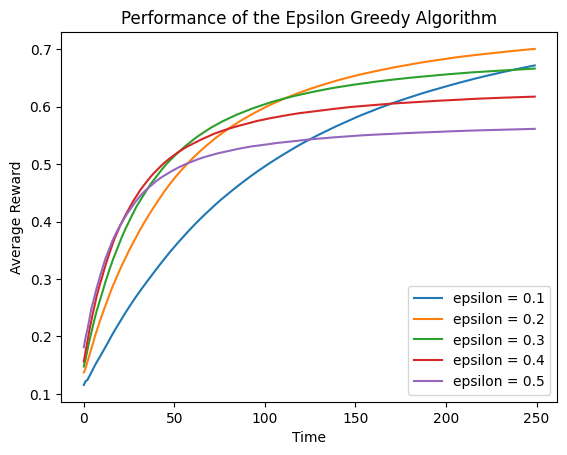

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def get_cumulative_reward(algo, arms, num_sims, horizon):
    """测试算法框架

    Args:
        algo: 试图测试的bandit算法框架
        arms: 模拟绘制的臂的数组
        num_sims: 模拟的次数
        horizon: 每个算法在每次模拟期间被允许拉动臂的次数

    Returns:
        在每次试验中获得的平均累计奖励
    """
    result = []

    for sim in range(num_sims):
        cumulative_rewards = [0.0 for i in range(horizon)]
        algo.initialize(len(arms))
        for t in range(horizon):
            t = t + 1
            index =  t - 1

            # 选择臂
            chosen_arm = algo.select_arm()

            # 模拟拉动臂的结果
            reward = arms[chosen_arm].draw()

            # 记录算法收到的奖励金，然后调用更新
            if t == 1:
                cumulative_rewards[index] = reward
            else:
                cumulative_rewards[index] = cumulative_rewards[index - 1] + reward

            algo.update(chosen_arm, reward)
        result.append(cumulative_rewards)
    
    # 多次模拟求平均
    average = np.sum(np.array(result),axis=0) / num_sims
    
    return list(average)

def draw_average_reward(arms, epsilons, num_sims=5000, times=250):
    result = []

    for epsilon in epsilons:
        algo = EpsilonGreedy(epsilon, [], [])
        algo.initialize(n)
        cumulative_rewards = get_cumulative_reward(algo, arms, num_sims, times)

        average = list(
            map(lambda x: x / (cumulative_rewards.index(x) + 1),
                cumulative_rewards))
        result.append(average)

    i = 0
    for res in result:
        plt.plot(res, label='epsilon = {0}'.format(epsilons[i]))
        i += 1

    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Average Reward')
    plt.title('Performance of the Epsilon Greedy Algorithm')
    plt.show()


means = [0.1, 0.1, 0.1, 0.1, 0.9]
epsilons = [0.1, 0.2, 0.3, 0.4, 0.5]
n = len(means)
random.shuffle(means)
arms = list(map(lambda mu: BernoulliArm(mu), means))

draw_average_reward(arms, epsilons)

### 5.3 方法3：跟踪每个时间点的累积奖励

为了决定增加探索是否值得，我们不应该关注算法在任何特定时间点的性能，而应该关注它在一段时间内的累积性能。要做到这一点，我们可以分析我们的算法的累积奖励，这是一个算法在某个固定时间点之前为我们赢得的奖励总量。

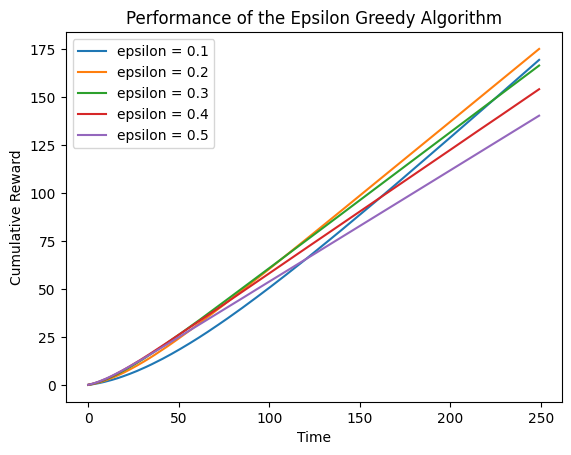

In [13]:
def draw_cumulative_reward(arms, epsilons, num_sims=5000, times=250):
    result = []

    for epsilon in epsilons:
        algo = EpsilonGreedy(epsilon, [], [])
        algo.initialize(n)
        cumulative_rewards = get_cumulative_reward(algo, arms, num_sims, times)

        result.append(cumulative_rewards)

    i = 0
    for res in result:
        plt.plot(res, label='epsilon = {0}'.format(epsilons[i]))
        i += 1

    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Cumulative Reward')
    plt.title('Performance of the Epsilon Greedy Algorithm')
    plt.show()

draw_cumulative_reward(arms, epsilons)

由上图可知，epsilon=0.1和epsilon=0.5的曲线在大约130轮后相交：在此之前，探索了很多是好的，但在此之后，一旦算法找到了最好的臂，能够更稳定地进行开发是更好的。

## 六、算法探索

为了真正了解epsilon贪婪算法，我们需要了解它在各种情况下的表现。

+ 使用不同数量的臂，而不是我们一直使用的五个臂。看看如果有2只臂，它会如何表现，然后再看看如果有200只臂，它会如何表现。

+ 改变伯努利臂的奖励概率。如果所有的概率都接近于0.0时，算法会有什么表现？它是如何表现的，所有的概率都接近1.0？当不同臂的概率相似时，它会如何表现？当概率相隔很远的时候，它会有什么表现？

### 6.1 改变臂的数量

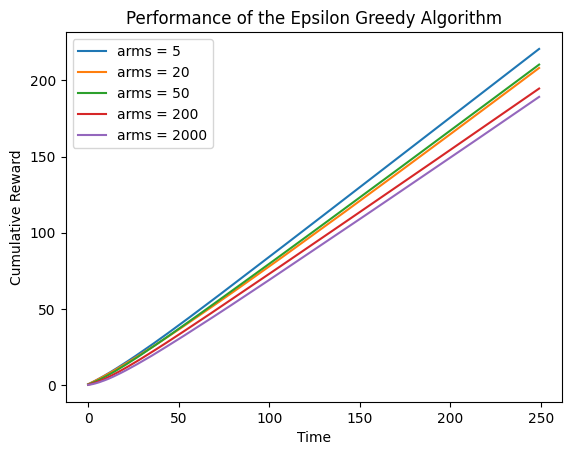

In [26]:
arms = []
nums = [5, 20, 50, 200, 2000]

# 随机生成数据
for num in nums:
    temp = [0.0 for col in range(num)]
    for i in range(num):
        temp[i] = random.random()
    means = list(map(lambda mu: BernoulliArm(mu), temp))
    arms.append(means)

result = []

for ar in arms:
    algo = EpsilonGreedy(0.2, [], [])
    algo.initialize(n)
    cumulative_rewards = get_cumulative_reward(algo, ar, 5000, len(arms))

    result.append(cumulative_rewards)

i = 0
for res in result:
    plt.plot(res, label='arms = {0}'.format(nums[i]))
    i += 1

plt.legend()
plt.xlabel('Time')
plt.ylabel('Cumulative Reward')
plt.title('Performance of the Epsilon Greedy Algorithm')
plt.show()

由上图可知，臂的奖励概率随机，epsilon固定为0.2，摇臂次数固定为250时，随着臂的增加，累计奖励呈现递减趋势。

### 6.2 改变臂的奖励概率

#### 所有的概率接近0.0时

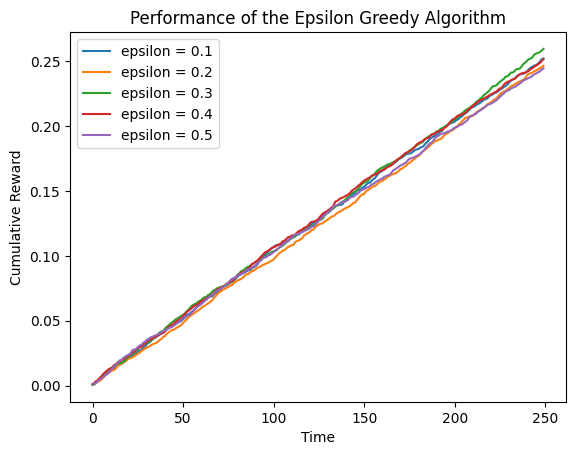

In [28]:
means = [0.001, 0.001, 0.001, 0.001, 0.001]
n = len(means)
random.shuffle(means)
arms = list(map(lambda mu:BernoulliArm(mu), means))
draw_cumulative_reward(arms, epsilons)

可以看到，累计奖励接近于0。

#### 所有的概率接近1.0时

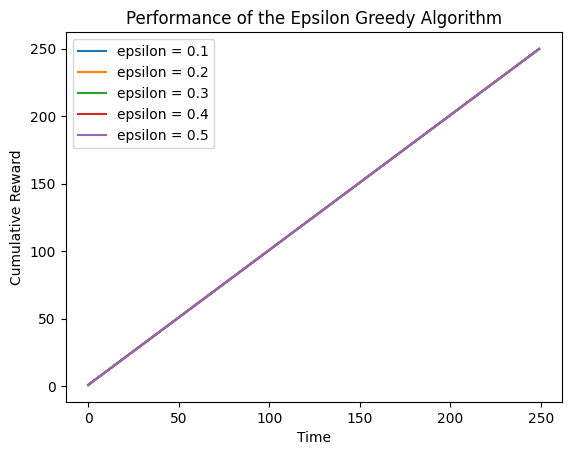

In [29]:
means = [0.999, 0.999, 0.999, 0.999, 0.999]
n = len(means)
random.shuffle(means)
arms = list(map(lambda mu:BernoulliArm(mu), means))
draw_cumulative_reward(arms, epsilons)

可以看到，累计奖励接近于次数250。

#### 不同臂的概率近似时



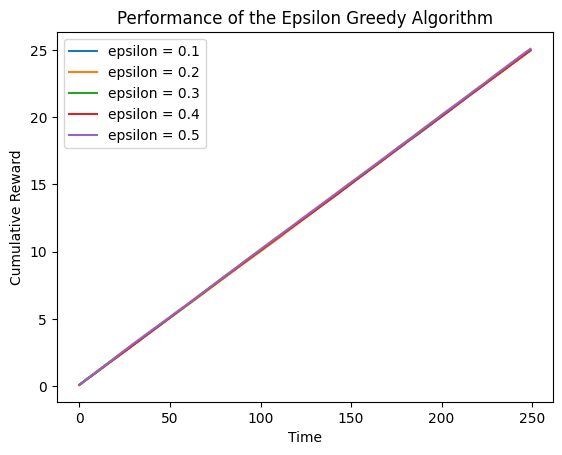

In [30]:
means = [0.1, 0.1, 0.1, 0.1, 0.1]
n = len(means)
random.shuffle(means)
arms = list(map(lambda mu:BernoulliArm(mu), means))
draw_cumulative_reward(arms, epsilons)

可以看到，累计奖励近似于单臂的奖励概率$\times$ Time

#### 不同臂的概率相差较远时



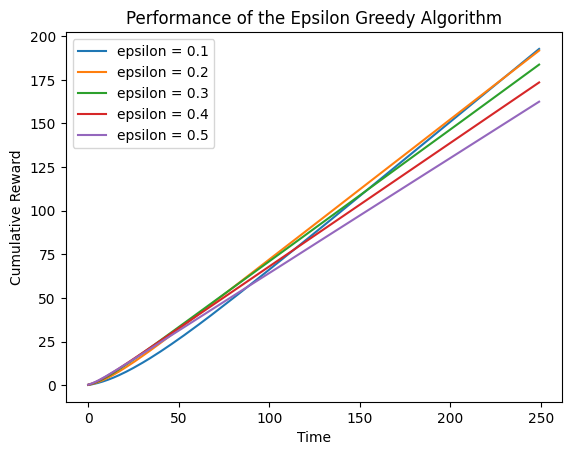

In [31]:
means = [0.1, 0.9, 0.1, 0.9, 0.1]
n = len(means)
random.shuffle(means)
arms = list(map(lambda mu:BernoulliArm(mu), means))
draw_cumulative_reward(arms, epsilons)

与第五节的结果类似。

## 七、算法改进

使用模拟退火算法对epsilon进行优化如下。

In [32]:
import random
import math

def ind_max(x):
    """  
    获取向量x的最大值的索引
    """
    m = max(x)
    return x.index(m)

class AnnealingEpsilonGreedy():
  def __init__(self, counts, values):
    self.counts = counts
    self.values = values
    return

  def initialize(self, n_arms):
    self.counts = [0 for col in range(n_arms)]
    self.values = [0.0 for col in range(n_arms)]
    return

  def select_arm(self):
    t = sum(self.counts) + 1
    # 模拟退火
    epsilon = 1 / math.log(t + 0.0000001)
    
    if random.random() > epsilon:
      # 利用已知最佳的臂
      return ind_max(self.values)
    else:
      # 随机探索
      return random.randrange(len(self.values))
  
  def update(self, chosen_arm, reward):
        """更新算法

        Args:
            chosen_arm: 最近选择的arm的索引
            reward: 选择该arm获得的奖励
        """        
        # 选择次数增加
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]

        value = self.values[chosen_arm]
        # 加权平均
        new_value = ((n-1)/float(n))*value + (1/float(n)) * reward
        self.values[chosen_arm] = new_value
        return


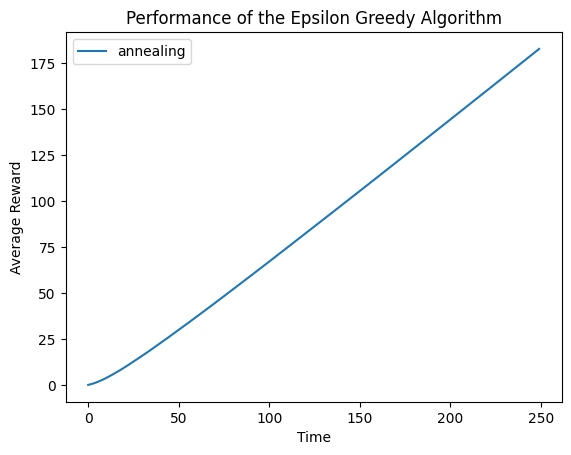

In [37]:
# seed( ) 用于指定随机数生成时所用算法开始的整数值，如果使用相同的seed( )值，
# 则每次生成的随即数都相同
random.seed(1)
means = [0.1, 0.1, 0.1, 0.1, 0.9]
n = len(means)
random.shuffle(means)
arms = list(map(lambda mu:BernoulliArm(mu), means))

algo = AnnealingEpsilonGreedy([], [])
algo.initialize(n)
cumulative_rewards = get_cumulative_reward(algo, arms, 5000, 250)

plt.plot(cumulative_rewards, label='annealing')


plt.legend()
plt.xlabel('Time')
plt.ylabel('Average Reward')
plt.title('Performance of the Epsilon Greedy Algorithm')
plt.show()

对比可知，使用改进后的算法，累计奖励会更多一些。